## Amazon Electronics Product review sentiment analyzer



### Problem Statement

Develop a sentiment analysis model using machine learning techniques in a Jupyter Notebook for the Amazon electronic product reviews dataset. The goal is to classify the sentiment of the reviews as positive, negative, or neutral based on the text content. The model should be able to accurately predict the sentiment of new reviews and provide insights into customer opinions regarding electronic products on Amazon.

### Dataset Details

The dataset can be found on Kaggle at the following link: Amazon Reviews 2018 (Electronics). It contains a collection of reviews for electronic products sold on Amazon, along with corresponding ratings and other metadata. The dataset will be used to train and test the sentiment analysis model.The dataset is available in kaggle at this [Link](https://www.kaggle.com/datasets/magdawjcicka/amazon-reviews-2018-electronics).

In [1]:
import pandas as pd
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

C:\Users\sid32\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('electronics_small.csv')

C:\Users\sid32\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df.head()

,overall,vote,verified,reviewTime,reviewText,summary
0,5,67,True,1999-09-18,This is the best novel I have read in 2 or 3 y...,A star is born
1,3,5,True,2013-10-23,"Pages and pages of introspection, in the style...",A stream of consciousness novel
2,5,4,True,2008-09-02,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...
3,5,13,True,2000-09-04,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!
4,3,8,True,2000-02-04,I was taken in by reviews that compared this b...,A dissenting view--In part.


In [4]:
df.shape

(3000000, 6)

In [6]:
df.overall.value_counts()

5    1909431
4     520339
3     228272
1     205790
2     136168
Name: overall, dtype: int64

In [7]:
# Define a function to categorize sentiment
def categorize_sentiment(overall):
    if overall >= 3:
        return 0
    
    else:
        return 1

# Create new column 'sentiment'
df['sentiment'] = df['overall'].apply(categorize_sentiment)

In [8]:
df.sentiment.value_counts()

0    2658042
1     341958
Name: sentiment, dtype: int64

In [9]:
# Count of each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Find the minimum count among all sentiment categories
min_count = sentiment_counts.min()

# Sample from positive sentiment records to match the minimum count
sampled_df = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(min_count))


In [10]:
sampled_df.sentiment.value_counts()

0    341958
1    341958
Name: sentiment, dtype: int64

In [11]:
sampled_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewText', 'summary',
       'sentiment'],
      dtype='object')

In [12]:
X = sampled_df.drop(['overall','vote','verified','reviewTime','summary'],axis=1)

In [15]:
X.head()

,reviewText,sentiment
671245,Nav-Mat is a great solution...,0
1118927,"Good, but still in development",0
1002886,"Works very well, but a bit bulky",0
1691121,I've got four sets of headphones on duty in th...,0
1853696,This is okay. There is a usb cord that needs ...,0


In [16]:
X = X.reset_index()

In [17]:
X.loc[1, 'reviewText']

'Good, but still in development'

In [19]:
X['reviewText'] = X['reviewText'].str.replace('\n', '')
X['reviewText'] = X['reviewText'].str.replace('\'s', '')
X['reviewText'] = X['reviewText'].str.replace('"', '')
X['reviewText'] = X['reviewText'].str.replace('n\'t', ' not')

In [21]:
X.loc[15, 'reviewText']

'Great slim feel and responsive tip. Would continue to use this stylus. Great colors and can also use on iphone'

In [22]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [24]:
from bs4 import BeautifulSoup
import re

In [25]:
def review_to_words(raw_review):
    
    # 2. Make a space
    raw_review = str(raw_review)
    letters_only = re.sub('[^a-zA-Z]', ' ', raw_review)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [26]:
X['review_clean'] = X['reviewText'].apply(review_to_words)

In [27]:
X.head()

,index,reviewText,sentiment,review_clean
0,671245,Nav-Mat is a great solution...,0,nav mat great solution
1,1118927,"Good, but still in development",0,good still development
2,1002886,"Works very well, but a bit bulky",0,work well bit bulky
3,1691121,I've got four sets of headphones on duty in th...,0,got four set headphone duty household happy ge...
4,1853696,This is okay. There is a usb cord that needs ...,0,okay usb cord need plugged splitter computer s...


In [28]:
X_feat=X['review_clean']
y=X['sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=123)

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Vectorization

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

### Model Building & Evaluation

accuracy:   0.821
Confusion matrix, without normalization


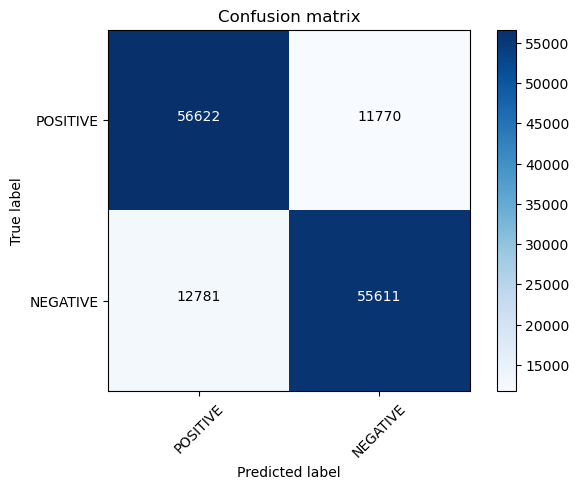

In [33]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0, 1])
plot_confusion_matrix(cm, classes=['POSITIVE', 'NEGATIVE'])

accuracy:   0.810
Confusion matrix, without normalization


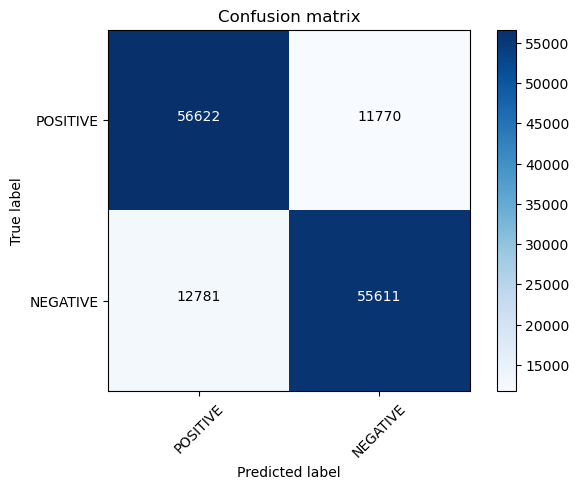

In [34]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred_1 = pass_tf.predict(tfidf_test_2)
score1 = metrics.accuracy_score(y_test, pred_1)
print("accuracy:   %0.3f" % score1)
cm = metrics.confusion_matrix(y_test, pred_1, labels=[0, 1])
plot_confusion_matrix(cm, classes=['POSITIVE', 'NEGATIVE'])

accuracy:   0.572
Confusion matrix, without normalization


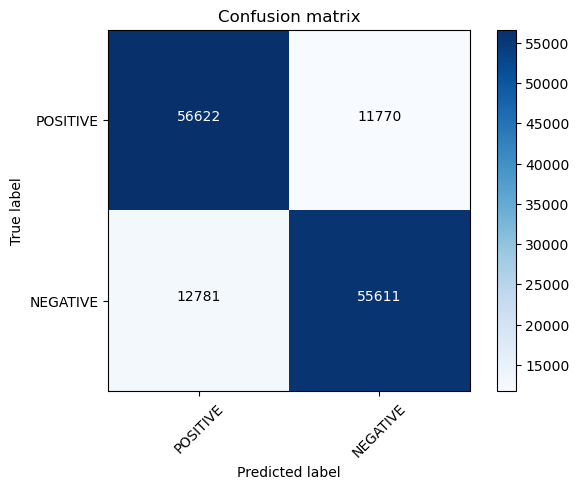

In [38]:
rf_ent = RandomForestClassifier(criterion='gini',max_depth=3,  n_estimators=50)
rf_ent.fit(tfidf_train_2, y_train)
pred_1 = rf_ent.predict(tfidf_test_2)
score1 = metrics.accuracy_score(y_test, pred_1)
print("accuracy:   %0.3f" % score1)
cm = metrics.confusion_matrix(y_test, pred_1, labels=[0, 1])
plot_confusion_matrix(cm, classes=['POSITIVE', 'NEGATIVE'])

C:\Users\sid32\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy:   0.831
Confusion matrix, without normalization


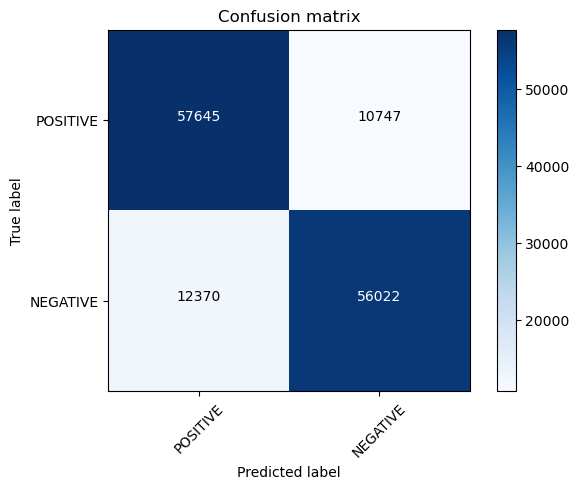

In [40]:
from sklearn.linear_model import LogisticRegression
lr =LogisticRegression()
lr.fit(tfidf_train_2, y_train)
pred_1 = lr.predict(tfidf_test_2)
score1 = metrics.accuracy_score(y_test, pred_1)
print("accuracy:   %0.3f" % score1)
cm = metrics.confusion_matrix(y_test, pred_1, labels=[0, 1])
plot_confusion_matrix(cm, classes=['POSITIVE', 'NEGATIVE'])

### Model Saving

In [45]:
import joblib
joblib.dump(tfidf_vectorizer2, 'sent_model/tfidfvectorizer.pkl')
joblib.dump(lr, 'sent_model/logReg.pkl')

['sent_model/logReg.pkl']

### Sample Prediction

In [44]:
vectorizer = joblib.load('tfidfvectorizer.pkl')
model = joblib.load('logReg.pkl')

prediction_proba = model.predict_proba(vectorizer.transform(["This is one of the  product i have ever purchased in my life"]))
prediction_probs = round(prediction_proba[0, 1], 2)
prediction_probs*100

54.0